In [1]:
#Clustering
#Clustering.py는 문장 임베딩 유사성을 기반으로 유사한 문장을 클러스터링하는 예를 보여줍니다.
# 참고 소스 : https://github.com/BM-K/KoSentenceBERT-ETRI

from sentence_transformers import SentenceTransformer, util
import numpy as np

#model_path = 'model/bmc_fpt_kowiki20200920.train_model_0225-s-bert-nli-sts-0303'
model_path = 'bongsoo/kpf-sbert-128d-v1'

/MOCOMSYS/anaconda3/envs/bong/lib/python3.9/site-packages/huggingface_hub/snapshot_download.py:6: FutureWarning: snapshot_download.py has been made private and will no longer be available from version 0.11. Please use `from huggingface_hub import snapshot_download` to import the only public function in this module. Other members of the file may be changed without a deprecation notice.
  warnings.warn(


In [2]:
embedder = SentenceTransformer(model_path)
print(embedder)

/MOCOMSYS/anaconda3/envs/bong/lib/python3.9/site-packages/huggingface_hub/file_download.py:621: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  warnings.warn(


SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': True}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Dense({'in_features': 768, 'out_features': 128, 'bias': True, 'activation_function': 'torch.nn.modules.activation.Tanh'})
)


In [3]:
# Corpus with example sentences
corpus = ['한 남자가 음식을 먹는다.',
          '한 남자가 빵 한 조각을 먹는다.',
          '그 여자가 아이를 돌본다.',
          '한 남자가 아이와 놀아주고 있다',
          '한 남자가 말을 탄다.',
          '한 여자가 바이올린을 연주한다.',
          '두 남자가 수레를 숲 속으로 밀었다.',
          '한 남자가 담으로 싸인 땅에서 백마를 타고 있다.',
          '원숭이 한 마리가 드럼을 연주한다.',
          '치타 한 마리가 먹이 뒤에서 달리고 있다.',
          '한 남자가 파스타를 먹는다.',
          '고릴라 의상을 입은 누군가가 드럼을 연주하고 있다.',
          '사자가 들판을 달리고 있다.',
          '한 여자가 레스토랑에서 스테이크를 먹고 있다.',
          '치타가 들판을 가로 질러 먹이를 쫓는다.']

In [4]:
# 모델을 통해 임베딩 계산
corpus_embeddings = embedder.encode(corpus)

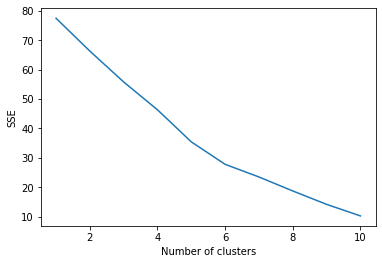

In [12]:
# 엘보우 그래프를 통한 최적 클러스터 수 지정
# 최적의 클러스터 수를 그래프로 보여줌.
# => 꺽이는 지점(엘보우)이 최적이 클러스터 수임.
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 클러스터 범위 지정
n_clusters_range = range(1, len(corpus))

# SSE 값 저장할 리스트
sse = []

for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=0)
    kmeans.fit(corpus_embeddings)
    sse.append(kmeans.inertia_)

plt.plot(n_clusters_range, sse)
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [20]:
# 실루엣 점수를 이용한 최적 클러스터수 지정
# -실루엣 점수는 클러스터 내의 응집도와 클러스터 간 분리도를 모두 고려하는 척도입니다. 
# -클러스터 수를 증가시키면서 실루엣 점수를 계산하고 가장 높은 값을 갖는 클러스터 수가 최적의 클러스터 수로 간주됩니다.
# - 실루엣 점수 범위는 0~1이고 1에 가까울수록 좋다.

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 임베딩이 저장된 리스트
embeddings = corpus_embeddings

# 클러스터 범위 지정
n_clusters_range = range(2, len(corpus))

# 실루엣 점수 저장할 리스트
silhouette_scores = []

print(f'*실루엣 스코어')
idx = 2
for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=0)
    kmeans.fit(embeddings)
    silhouette_scores.append(silhouette_score(embeddings, kmeans.labels_))
    print(f'{idx}:{silhouette_score(embeddings, kmeans.labels_)}')
    idx+=1

best_n_clusters = n_clusters_range[silhouette_scores.index(max(silhouette_scores))]

print(f'-------------------------------------------')
print(f'*Best number of clusters: {best_n_clusters}')

*실루엣 스코어
2:0.13515755534172058
3:0.1310611367225647
4:0.153165802359581
5:0.17212487757205963
6:0.1661088913679123
7:0.12242641299962997
8:0.13270752131938934
9:0.11929821968078613
10:0.12955625355243683
11:0.10894379019737244
12:0.0806831493973732
13:0.04966308921575546
14:0.021569401025772095
-------------------------------------------
*Best number of clusters: 5


In [17]:
# 클러스터링 처리함.
# => 이때 최적 클러스터수는 위에서 구한 실루엣 점수를 이용함
corpus_embeddings = embedder.encode(corpus)

# Then, we perform k-means clustering using sklearn:
from sklearn.cluster import KMeans

num_clusters = best_n_clusters
clustering_model = KMeans(n_clusters=num_clusters, init='k-means++', random_state=0)
clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_

clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append(corpus[sentence_id])

for i, cluster in enumerate(clustered_sentences):
    print("Cluster ", i+1)
    print(cluster)
    print("")

Cluster  1
['한 남자가 음식을 먹는다.', '한 남자가 빵 한 조각을 먹는다.', '한 남자가 말을 탄다.', '두 남자가 수레를 숲 속으로 밀었다.', '한 남자가 담으로 싸인 땅에서 백마를 타고 있다.', '치타 한 마리가 먹이 뒤에서 달리고 있다.', '사자가 들판을 달리고 있다.', '한 여자가 레스토랑에서 스테이크를 먹고 있다.', '치타가 들판을 가로 질러 먹이를 쫓는다.']

Cluster  2
['한 여자가 바이올린을 연주한다.']

Cluster  3
['원숭이 한 마리가 드럼을 연주한다.', '고릴라 의상을 입은 누군가가 드럼을 연주하고 있다.']

Cluster  4
['그 여자가 아이를 돌본다.', '한 남자가 아이와 놀아주고 있다']

Cluster  5
['한 남자가 파스타를 먹는다.']

